# Homework #3 (Due 10/01/2020, 11:59pm)
## Sampling and Monte Carlo Integration

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [2]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Description

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of the random variable $X$:

$$
h(x) = 7 * \mathrm{exp}\left\{\frac{(x-4)^2}{-2}\right\} + 3 * \mathrm{exp}\left\{\frac{(x-8)^2}{-2 * 0.7^2}\right\}
$$

Our goal is to compute the expected value of $h(X)$:
$$
I = \mathbb{E}_{X\sim f_X}\left[h(X)\right] = \int_{\Omega} h(x) f_X(x)dx,
$$
where $\Omega$ is the domain of $f_X$.

## Part I. Implement Some Monte Carlo Estimates

Approximate $\mathbb{E}_{X\sim f_X}[h(X)]$ using the Monte Carlo integration methods and your choice of a reasonable fixed $S$ (for rejection sampling, this means run the algorithm $S$ times):


1. ***Inverse CDF Sampling*** and naive Monte Carlo estimation.<br><br>

2. ***Rejection Sampling*** and naive Monte Carlo estimation, using each of the following

  - a uniform proposal distribution
  - a normal proposal distribution 

  and your choice of reasonable parameters for the proposal distributions.<br><br>
  
3. ***Importance Sampling*** using each of the following

  - a uniform importance distribution 
  - a normal importance distribution

  and your choice of reasonable parameters for the importance distributions.<br><br>
  
2. ***Stratified Sampling*** using 4 strata, whose end points are given by
$$
[1, 3, 5, 6, 9].
$$
Use inverse cdf sampling on each stratum.

### Vizualisation the distribution of X 

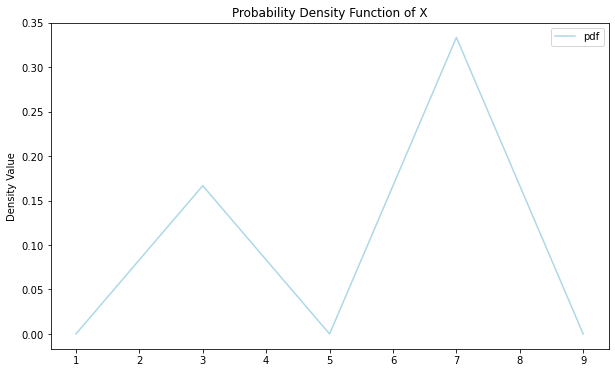

In [130]:
x = np.linspace(1, 9, 1001)
pdf = np.concatenate((1/12*(x[:251]-1), -1/12*(x[251:500]-5), 1/6*(x[500:751]-5), -1/6*(x[751:]-9)), axis = 0)
plt.figure(figsize = (10, 6))
plt.plot(x, pdf, color='lightblue', label = 'pdf')
plt.title('Probability Density Function of X')
plt.ylabel('Density Value')
plt.legend(loc='best')
plt.show()

### Computing the cdf of X

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

We know that in order to compute $\textbf{F}_X$, we can use the relation $\textbf{F}_X(x) = \int^xf_x(y)dy =  \int_1^xf_x(y)dy$

Therefore, we know that $ \forall x < 1 \quad \textbf{F}_X = 0$ and $\forall x > 9 \quad \textbf{F}_X = 1$. We resolve for the integration constants thanks to these two boundary limits. 

$$
F_X(x) = \begin{cases}
\frac{1}{12}(\frac{x^2}{2}-x) + \frac{1}{24}, &1\leq x\leq 3\\
-\frac{1}{12}(\frac{x^2}{2}-5x) - \frac{17}{24}, &3< x\leq 5\\
\frac{1}{6}(\frac{x^2}{2}-5x) + \frac{29}{12}, &5< x\leq 7\\
-\frac{1}{6}(\frac{x^2}{2}-9x) - \frac{69}{12}, &7< x\leq 9\\
\end{cases}
$$

I have checked that with these values, $F_X$ is well defined and continous for $x \in {1, 3, 5, 7, 9}$.

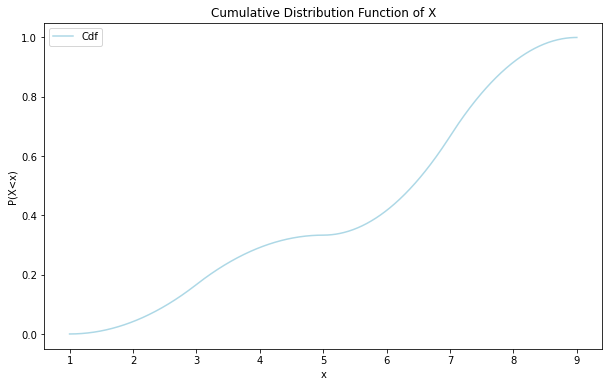

In [38]:
x = np.linspace(1, 9, 1001)
x1, x2, x3, x4 = x[:251], x[251:500], x[500:751], x[751:]
cdf = np.concatenate((1/12*(x1**2/2-x1)+1/24, -1/12*(x2**2/2-5*x2)-17/24, 1/6*(x3**2/2-5*x3)+29/12, -1/6*(x4**2/2-9*x4)-69/12), axis = 0)
plt.figure(figsize = (10, 6))
plt.plot(x, cdf, color='lightblue', label = 'Cdf')
plt.title('Cumulative Distribution Function of X')
plt.xlabel('x')
plt.ylabel('P(X<x)')
plt.legend(loc='best')
plt.show()

### Computing the inverse cdf of X 

From the definition of the cdf $F_X$, we know that $F^{-1}_X$ is defined : $[0, 1] \mapsto [0, 9]$ (where $F_X$is strictly monotonous).
$$
F^{-1}_X(y) = \begin{cases}
1 +2*\sqrt{6y} & 0 \leq y\leq \frac{1}{6}\\
5 - 2\sqrt{2(1-3y)}&\frac{1}{6}  \leq y\leq \frac{1}{3}\\
5 + 2\sqrt{3y-1}, &\frac{1}{3} \leq y\leq \frac{2}{3}\\
9 - 2\sqrt{3(1-y)}, &\frac{2}{3} \leq y\leq 1\\
\end{cases}
$$

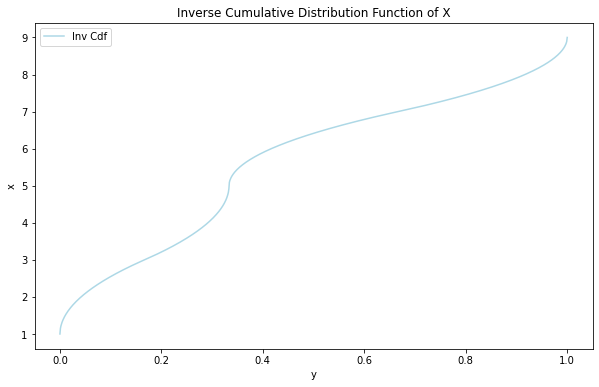

In [47]:
x = np.linspace(0, 1, 1001)
x1, x2, x3, x4 = x[:166], x[166:334], x[334:667], x[667:]
cdf_inv = np.concatenate((1+2*np.sqrt(6*x1), 5-2*np.sqrt(2*(1-3*x2)), 5+2*np.sqrt(3*x3-1), 9-2*np.sqrt(3*(1-x4))), axis = 0)
plt.figure(figsize = (10, 6))
plt.plot(x, cdf_inv, color='lightblue', label = 'Inv Cdf')
plt.title('Inverse Cumulative Distribution Function of X')
plt.xlabel('y')
plt.ylabel('x')
plt.legend(loc='best')
plt.show()

In [342]:
def pdf(x):   
    if 1 <= x < 3:
        return 1/12*(x-1)
    if 3 <= x < 5:
        return -1/12*(x-5)
    if 5 <= x < 7:
        return 1/6*(x-5)
    if 7 <= x < 9:
        return -1/6*(x-9)
    else:
        return 0

def cdf(x): 
    if x < 1:
        return 0
    if 1 <= x < 3:
        return 1/12*(x**2/2-x)+1/24
    if 3 <= x < 5:
        return -1/12*(x**2/2-5*x)-17/24
    if 5 <= x < 7:
        return 1/6*(x**2/2-5*x)+29/12
    if 7 <= x < 9:
        return -1/6*(x**2/2-9*x)-69/12
    else:
        return 1

def cdf_inv(y):
    if 0 <= y < 1/6:
        return 1+2*np.sqrt(6*y)
    if 1/6 <= y < 1/3:
        return 5-2*np.sqrt(2*(1-3*y))
    if 1/3 <= y < 2/3:
        return 5+2*np.sqrt(3*y-1)
    else:
        return 9-2*np.sqrt(3*(1-y))
    
def h(x):
    return 7*np.exp(-(x-4)**2/2) + 3*np.exp(-(x-8)**2/(2*0.7**2))

### 1. Simulation of the random variable X through inverse cdf method

#### Simulation of 1000 random variables $X_i \sim X$

In [60]:
U = np.random.uniform(0, 1, size = 1000)
Xis = [cdf_inv(u) for u in U]

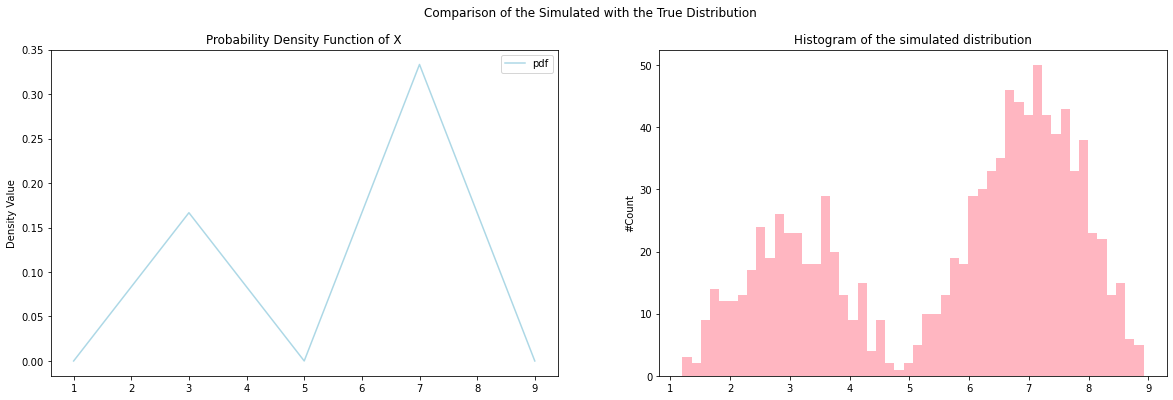

In [129]:
x = np.linspace(1, 9, 1001)
pdf = np.concatenate((1/12*(x[:251]-1), -1/12*(x[251:500]-5), 1/6*(x[500:751]-5), -1/6*(x[751:]-9)), axis = 0)
fig, axes = plt.subplots(1, 2 , figsize = (20, 6))
fig.suptitle('Comparison of the Simulated with the True Distribution')
axes[0].plot(x, pdf, color='lightblue', label = 'pdf')
axes[0].set_title('Probability Density Function of X')
axes[0].set_ylabel('Density Value')
axes[0].legend(loc='best')
axes[1].hist(Xis, bins=50, color='lightpink')
axes[1].set_title('Histogram of the simulated distribution')
axes[1].set_ylabel('#Count')
plt.show()

### Approximation of $\mathbb{E}_{X\sim f_X}[h(X)]$ using Naive Monte Carlo and Variance Estimation

In [81]:
H = [h(Xi) for Xi in Xis]
I = np.mean(H)
print('Through Naive Monte Carlo Estimate, the value of the Expectancy is', I)

Through Naive Monte Carlo Estimate, the value of the Expectancy is 2.392038898793919


In [211]:
n_simu = 100
integral_calculation = []
for i in range(n_simu):
    U = np.random.uniform(0, 1, size = 1000)
    Xis = [cdf_inv(u) for u in U]
    H = [h(Xi) for Xi in Xis]
    I = np.mean(H)
    integral_calculation.append(I)
print('Through Naive Monte Carlo Estimate, the variance of our estimate is', np.var(integral_calculation))

Through Naive Monte Carlo Estimate, the variance of our estimate is 0.0033865498457419426


### 2. Simulation of the random variable X through Rejection sampling

$\textbf{Hypotheses to be verified in order to select a proposal distribution for Rejection Sampling.}$

#### With a uniform proposal distribution

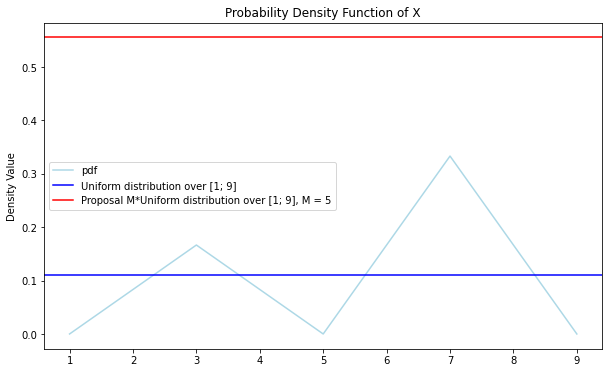

In [128]:
x = np.linspace(1, 9, 1001)
pdf = np.concatenate((1/12*(x[:251]-1), -1/12*(x[251:500]-5), 1/6*(x[500:751]-5), -1/6*(x[751:]-9)), axis = 0)
plt.figure(figsize = (10, 6))
plt.plot(x, pdf, color='lightblue', label = 'pdf')
plt.axhline(y = 1/9, color='blue', label='Uniform distribution over [1; 9]')
plt.axhline(y = 5*1/9, color='red', label='Proposal M*Uniform distribution over [1; 9], M = 5')
plt.title('Probability Density Function of X')
plt.ylabel('Density Value')
plt.legend(loc='best')
plt.show()

In [208]:
S = 5000
M1 = 5
accepted_samples = []
for i in range(S):
    Y_tent = np.random.uniform(1, 9)
    threshold = np.random.uniform(0, 1)
    if threshold*M1*1/9 < pdf(Y_tent):
        accepted_samples.append(Y_tent)

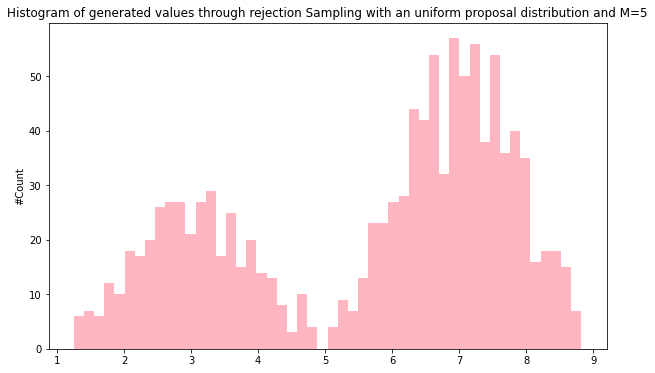

In [209]:
plt.figure(figsize = (10, 6))
plt.hist(accepted_samples, bins=50, color='lightpink')
plt.ylabel('#Count')
plt.title('Histogram of generated values through rejection Sampling with an uniform proposal distribution and M=5')
plt.show()

#### Approximation of $\mathbb{E}_{X\sim f_X}[h(X)]$ using Naive Monte Carlo and Variance Estimation

In [210]:
H = [h(Xi) for Xi in accepted_samples]
I = np.mean(H)
print('Through Naive Monte Carlo Estimate, the value of the Expectancy is', I)

Through Naive Monte Carlo Estimate, the value of the Expectancy is 2.486008156659029


In [214]:
n_simu = 100
S = 5000
M1 = 5
integral_calculation = []
for i in range(n_simu):
    accepted_samples = []
    for i in range(S):
        Y_tent = np.random.uniform(1, 9)
        threshold = np.random.uniform(0, 1)
        if threshold*M1*1/9 < pdf(Y_tent):
            accepted_samples.append(Y_tent)
    H = [h(Xi) for Xi in Xis]
    I = np.mean(H)
    integral_calculation.append(I)
print('Through Naive Monte Carlo Estimate, the variance of our estimate is', np.var(integral_calculation))

Through Naive Monte Carlo Estimate, the variance of our estimate is 1.9721522630525295e-31


#### Using a normal proposal distribution

First, we are going to find the parameters of the Gaussian distribution in order to verify the hypothesis of rejection sampling. 

In [191]:
import scipy
mu = 5.6
sigma = 3.2

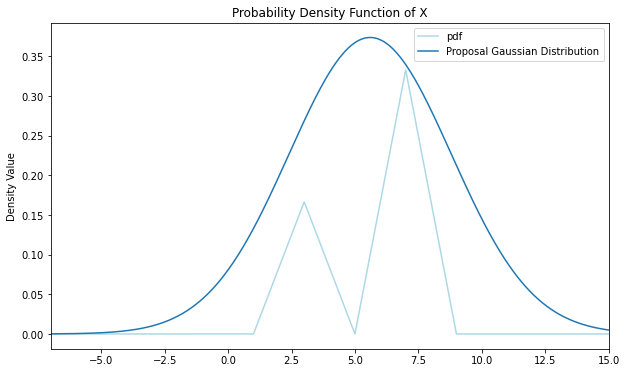

In [192]:
x = np.linspace(-15,15, 10000)
distribu = [pdf(y) for y in x]
plt.figure(figsize = (10, 6))
plt.plot(x, distribu, color='lightblue', label = 'pdf')
plt.plot(x, 3*scipy.stats.norm.pdf(x, mu, sigma), label = 'Proposal Gaussian Distribution')
plt.xlim([-7, 15])
plt.title('Probability Density Function of X')
plt.ylabel('Density Value')
plt.legend(loc='best')
plt.show()

In [215]:
S = 5000
M2 = 3
accepted_samples = []
for i in range(S):
    Y_tent = np.random.normal(mu, sigma)
    threshold = np.random.uniform(0, 1)
    if threshold*M2*scipy.stats.norm.pdf(Y_tent, mu, sigma) < pdf(Y_tent):
        accepted_samples.append(Y_tent)

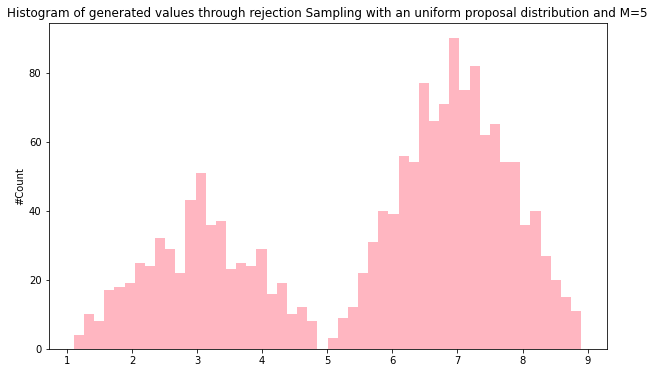

In [216]:
plt.figure(figsize = (10, 6))
plt.hist(accepted_samples, bins=50, color='lightpink')
plt.ylabel('#Count')
plt.title('Histogram of generated values through rejection Sampling with an uniform proposal distribution and M=5')
plt.show()

#### Approximation of $\mathbb{E}_{X\sim f_X}[h(X)]$ using Naive Monte Carlo and Variance Estimation

In [217]:
H = [h(Xi) for Xi in accepted_samples]
I = np.mean(H)
print('Through Naive Monte Carlo Estimate, the value of the Expectancy is', I)

Through Naive Monte Carlo Estimate, the value of the Expectancy is 2.438040674112891


In [218]:
n_simu = 100
S = 5000
M3 = 3
integral_calculation = []
for i in range(n_simu):
    accepted_samples = []
    for i in range(S):
        Y_tent = np.random.normal(mu, sigma)
        threshold = np.random.uniform(0, 1)
        if threshold*M2*scipy.stats.norm.pdf(Y_tent, mu, sigma) < pdf(Y_tent):
            accepted_samples.append(Y_tent)
    H = [h(Xi) for Xi in Xis]
    I = np.mean(H)
    integral_calculation.append(I)
print('Through Naive Monte Carlo Estimate, the variance of our estimate is', np.var(integral_calculation))

Through Naive Monte Carlo Estimate, the variance of our estimate is 1.9721522630525295e-31


### 3. Computation of $\mathbb{E}_{X\sim f_X}[h(X)]$ through Importance sampling

$\textbf{Hypotheses to be verified for the 'easy' distribution q for an efficient Importance Sampling Variance Reduction. }$

#### With an uniform proposal distribution

In [223]:
S = 1000
samples = np.random.uniform(1, 9, S)
weights = np.asarray([pdf(sample)/(1/9) for sample in samples])
H = np.asarray([h(u) for u in samples])
I_imp_sampling = np.mean(weights*H)
print('Through Importance Sampling Estimate, the value of the Expectancy is', I_imp_sampling)


Through Importance Sampling Estimate, the value of the Expectancy is 2.778512478079588


#### With a Gaussian proposal distribution

In [224]:
mu = 5.6
sigma = 3.2

First, we wish to use a Proposal distribution that would be similar to the target one (i.e, p): we choose the Gaussian distribution with $\mu = 5.6 $ and $ \sigma=3.2$ 

In [225]:
S = 1000
samples = np.random.normal(mu, sigma, S)
weights = np.asarray([pdf(sample)/scipy.stats.norm.pdf(sample, mu, sigma) for sample in samples])
H = np.asarray([h(x) for x in samples])
I_imp_sampling = np.mean(weights*H)
print('Through Importance Sampling Estimate, the value of the Expectancy is', I_imp_sampling)


Through Importance Sampling Estimate, the value of the Expectancy is 2.4677758735799205


### 4. Computation of $\mathbb{E}_{X\sim f_X}[h(X)]$ through Rejection Sampling and Stratification for Computing the Monte Carlo Approximation

The strata we will use for Variance Reduction through stratification are [1, 3], [3, 5], [5, 7] and [7, 9].

First, let us compute the $\textbf{weights for stratification}$. 
$$
w_k = \int_{t_k}^{t_{k+1}}f_X(y)dy = F_X(k+1) - F_X(k)
$$

In [226]:
w1, w2, w3, w4 = cdf(3)-cdf(1), cdf(5)-cdf(3), cdf(7)-cdf(5), cdf(9)-cdf(7)

In [261]:
S = 1000
S1, S2, S3, S4 = int(w1*S), int(w2*S), int(w3*S), int(w4*S)

In [247]:
U = np.random.uniform(0, 1, size = 10000)
Xis = np.array([cdf_inv(u) for u in U])

In [258]:
import random

In [263]:
strata_1 = random.sample(list(Xis[Xis < 3]), k=S1)
strata_2 = random.sample(list(Xis[(Xis > 3) & (Xis < 5)]), k=S2)
strata_3 = random.sample(list(Xis[(Xis > 5) & (Xis < 7)]), k=S3)
strata_4 = random.sample(list(Xis[(Xis > 7) & (Xis < 9)]), k=S4)

In [264]:
h1 = [h(s1) for s1 in strata_1]
h2 = [h(s2) for s2 in strata_2]
h3 = [h(s3) for s3 in strata_3]
h4 = [h(s4) for s4 in strata_4]

In [266]:
I_strata = np.sum([w1*np.mean(h1), w2*np.mean(h2), w3*np.mean(h3), w4*np.mean(h4)])
print('Through Inverse cdf Sampling and Stratification Variance Reduction, the value of the Expectancy is', I_strata)


Through Inverse cdf Sampling and Stratification Variance Reduction, the value of the Expectancy is 2.4249307101870414


## Part II. Debug Your Samplers

1. Visualize the pdf $f_X$ as well as samples obtained from Inverse CDF Sampling and Rejection Sampling (for both proposal distributions). It's probably better to make separate plots for each set of samples.

  What does the comparison say about the quality of your samples? In particular, which sampler (and which proposal distribution) produces "better" samples? Is this surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?
  
  **Hint:** you might find it helpful to visualize the proposal distributions along with $f_X$ in your analysis of rejection sampling.<br><br>

2. Visualize the distribution of the importance weights (one for each importance distribution). 
  
   Is the weight distribution surprising -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?

   What do these importance weights tell you about the quality of your importance sampling estimate? 
   
     **Hint:** you might find it helpful to visualize the importnce distributions along with $f_X$ and $h$ in your analysis of importance sampling.<br><br>
     
3. Visualize the distribution of all the samples across strata. Is the distribution what you expect -- i.e. use some properties of these samplers discussed in class to explain the patterns you're observing?<br><br>

4. (**Extra Credit**) Compute the ***effective sample size (ESS)*** of the importance sampling estimates (for both distributions). You'll need to look up the definition of ESS (there are three commonly used definitions, pick any one). How does the effective sample size relate to the trends in the importance weight distributions?

$\textbf{I have not seen these questions before working on the question 1, so the plots might be redundant but I will try to carefully analyse here the results in regard with the Lectures we had on sampling and Variance Reduction.}$

### 1. Analysis of Inverse CDF Sampling and Rejection Sampling

#### Objective Distribution

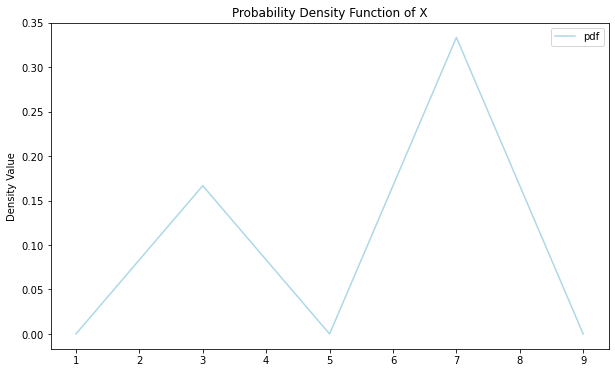

In [267]:
x = np.linspace(1, 9, 1001)
pdf = np.concatenate((1/12*(x[:251]-1), -1/12*(x[251:500]-5), 1/6*(x[500:751]-5), -1/6*(x[751:]-9)), axis = 0)
plt.figure(figsize = (10, 6))
plt.plot(x, pdf, color='lightblue', label = 'pdf')
plt.title('Probability Density Function of X')
plt.ylabel('Density Value')
plt.legend(loc='best')
plt.show()

#### Inverse cdf Sampling

In [273]:
import seaborn as sns

In [275]:
U = np.random.uniform(0, 1, size = 1000)
Xis = [cdf_inv(u) for u in U]

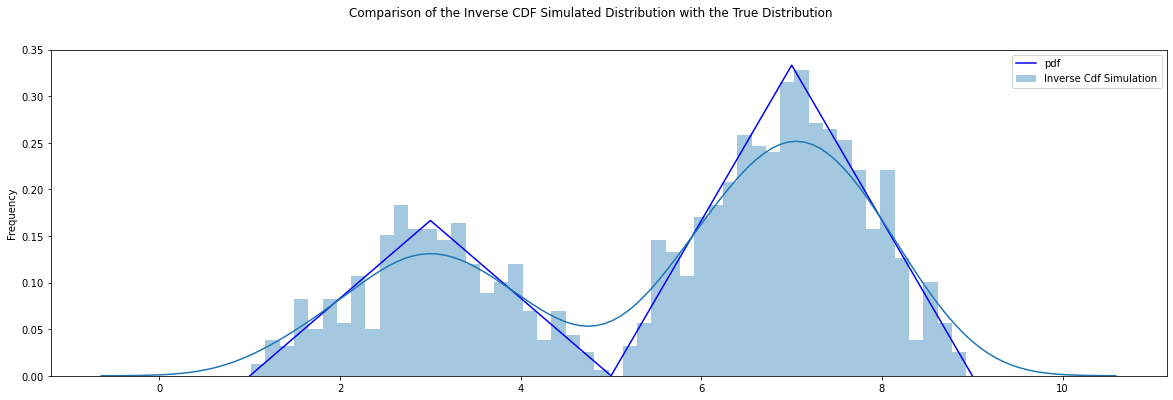

In [283]:
x = np.linspace(1, 9, 1001)
pdf = np.concatenate((1/12*(x[:251]-1), -1/12*(x[251:500]-5), 1/6*(x[500:751]-5), -1/6*(x[751:]-9)), axis = 0)
fig, axes = plt.subplots(1, figsize = (20, 6))
fig.suptitle('Comparison of the Inverse CDF Simulated Distribution with the True Distribution')
axes.plot(x, pdf, color='blue', label = 'pdf')
axes.set_ylabel('Density Value')
sns.distplot(Xis, bins = 50, label='Inverse Cdf Simulation')
axes.set_ylabel('Frequency')
axes.legend(loc='best')
plt.show()

For Inverse cdf Sampling, we can see that the samples produced are of relatively good quality. With only 1000 simulations, we quite reproduce the target distribution and the histogram of values is reliable. These good results come from the fact that this method is pretty $\textbf{straightforward}$: for distributions with a close form for the Inverse of the cdf, we can directly create samples without further assumptions or parameters to be tuned.  

#### Rejection sampling: Uniform and Gaussian Proposals

$\textbf{Vizualisation of the Proposal Distributions and Target Distributions for Rejection Sampling.}$

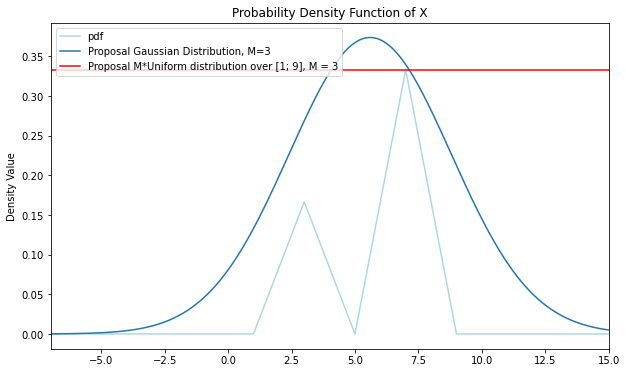

In [304]:
x = np.linspace(-15,15, 10000)
distribu = [pdf(y) for y in x]
plt.figure(figsize = (10, 6))
plt.plot(x, distribu, color='lightblue', label = 'pdf')
plt.plot(x, 3*scipy.stats.norm.pdf(x, mu, sigma), label = 'Proposal Gaussian Distribution, M=3')
plt.axhline(y = 3*1/9, color='red', label='Proposal M*Uniform distribution over [1; 9], M = 3')
plt.xlim([-7, 15])
plt.title('Probability Density Function of X')
plt.ylabel('Density Value')
plt.legend(loc='best')
plt.show()

$\textbf{Vizualisation of the sampled Distributions through Rejection Sampling}$

In [305]:
S = 1000
M1 = 3
accepted_samples_unif = []
for i in range(S):
    Y_tent = np.random.uniform(1, 9)
    threshold = np.random.uniform(0, 1)
    if threshold*M1*1/9 < pdf(Y_tent):
        accepted_samples_unif.append(Y_tent)

In [306]:
S = 1000
M2 = 3
accepted_samples_gaussian = []
for i in range(S):
    Y_tent = np.random.normal(mu, sigma)
    threshold = np.random.uniform(0, 1)
    if threshold*M2*scipy.stats.norm.pdf(Y_tent, mu, sigma) < pdf(Y_tent):
        accepted_samples_gaussian.append(Y_tent)

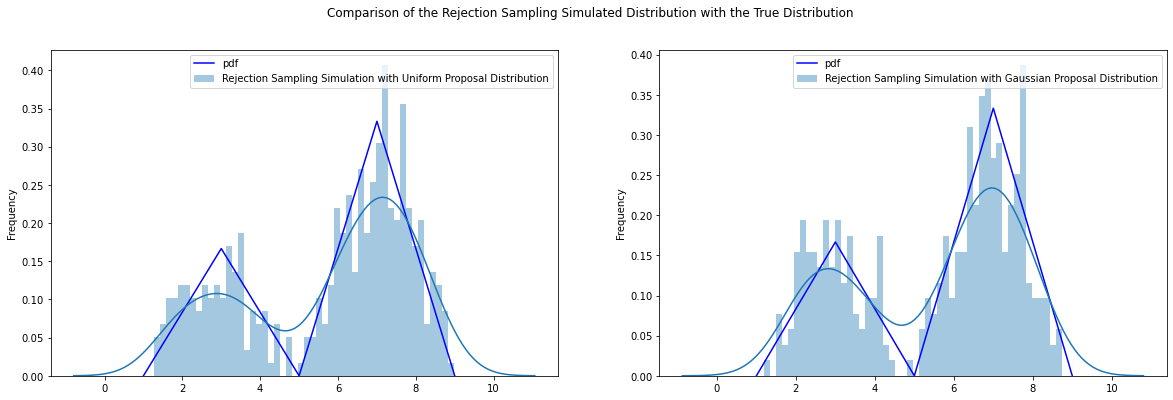

In [307]:
x = np.linspace(1, 9, 1001)
pdf_plot = np.concatenate((1/12*(x[:251]-1), -1/12*(x[251:500]-5), 1/6*(x[500:751]-5), -1/6*(x[751:]-9)), axis = 0)
fig, axes = plt.subplots(1, 2, figsize = (20, 6))
fig.suptitle('Comparison of the Rejection Sampling Simulated Distribution with the True Distribution')
axes[0].plot(x, pdf_plot, color='blue', label = 'pdf')
sns.distplot(accepted_samples_unif, bins = 50, label='Rejection Sampling Simulation with Uniform Proposal Distribution', ax = axes[0])
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')
axes[1].plot(x, pdf_plot, color='blue', label = 'pdf')
sns.distplot(accepted_samples_gaussian, bins = 50, label='Rejection Sampling Simulation with Gaussian Proposal Distribution', ax = axes[1])
axes[1].set_ylabel('Frequency')
axes[1].legend(loc='best')
plt.show()

In [308]:
print('Numbers of Accepted samples with Gaussian Proposal', len(accepted_samples_gaussian))
print('Numbers of Accepted samples with Uniform Proposal', len(accepted_samples_unif))


Numbers of Accepted samples with Gaussian Proposal 342
Numbers of Accepted samples with Uniform Proposal 383


First, we can observe that there are less samples produced for the Rejection Sampling than for the Inverse cdf method. This comes from the fact that for $\textbf{rejection}$ sampling, we $\textbf{reject}$ samples, depending on the vzlue of $M$. Therefore, here, for both methods, we expect to only accept $\frac{1}{M}*S \approx 300$ samples. This is why, in general, the quality of the rejection sampling will be inferior to the one of rejection sampling $\textit{ for the same number S of samples produced}$. 

Between the two rejection sampling samplers, the one producing "better" samples is the one leveraging the $\textbf{Gaussian Distribution}$: it does not produce samples for $x=5$ and decreases faster at $x = 1$ and $x=9$. However, using an Uniform Distribution as Using a Gaussian Distribution for this specific Distribution is not a very clever idea: for the uniform, we will produce samples with an abciss where the target pdf is low, and the place where the gaussian pdf is maximum (around $x=5$) is the place where the target pdf assigns a weight 0. Therefore, the proposal distributions do not closely approximate the target distribution. 

### 2. Analysis of Importance Sampling

$\textbf{Analysis of the weights of the Importance Sampling: }$what we expect from the distributions of the weights is to be high around values $x=3$ and $x=7$, quite low in the remainder of the support of the pdf $f_X$.

In [309]:
S = 1000
mu = 5.6
sigma = 3.2
samples_unif = np.random.uniform(1, 9, S)
weights_uniform = np.asarray([pdf(sample)/(1/9) for sample in samples_unif])
samples_gaussian = np.random.normal(mu, sigma, S)
weights_gaussian = np.asarray([pdf(sample)/scipy.stats.norm.pdf(sample, mu, sigma) for sample in samples_gaussian])

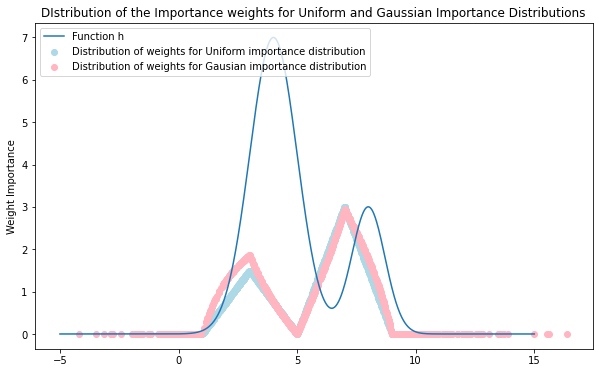

In [337]:
plt.figure(figsize=(10, 6))
x = np.linspace(-5, 15, 1000)
h = [h(y) for y in x]
plt.title('DIstribution of the Importance weights for Uniform and Gaussian Importance Distributions')
plt.scatter(samples_unif, weights_uniform, color='lightblue', label = 'Distribution of weights for Uniform importance distribution')
plt.scatter(samples_gaussian, weights_gaussian, color='lightpink', label = 'Distribution of weights for Gausian importance distribution')
plt.plot(x, h, label='Function h')
plt.ylabel('Weight Importance')
plt.legend(loc=2)
plt.show()

From the Importance weight distribution, we can deduce two things: we obtain distributions very similar to the target distribution, which is a good thing. However, we know that in order to get an effective Important Sampling estimate and effective Variance Reduction, we need to choose an important distribution $q$ that places more weight where $h(\theta)^2$ is important, which is not the case for any of the two important distributions selected here: both has higher values for $x = 7$ and lower values for $x = 3$, where the function $h$ is maximum. 

### 3. Analysis of Stratification

The idea of Stratification for Variance Reduction is to split the domain into sub-domains where the function will be relatively flat in order to reduce the artificially reduced naive Monte Carlo estimator. Let us here visualize the variations of h alongside with the strata we defined. 

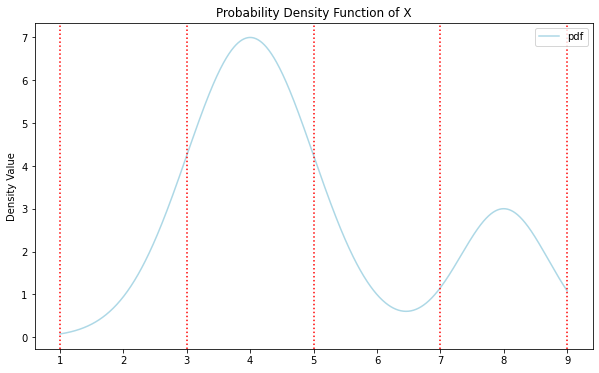

In [334]:
x = np.linspace(1, 9, 1001)
h = [h(y) for y in x]
plt.figure(figsize = (10, 6))
plt.plot(x, h, color='lightblue', label = 'pdf')
strata = [1, 3, 5, 7, 9]
for stratus in strata:
    plt.axvline(x=stratus, linestyle=':', color='red')
plt.title('Probability Density Function of X')
plt.ylabel('Density Value')
plt.legend(loc='best')
plt.show()

In [338]:
U = np.random.uniform(0, 1, size = 10000)
Xis = np.array([cdf_inv(u) for u in U])
strata_1 = random.sample(list(Xis[Xis < 3]), k=S1)
strata_2 = random.sample(list(Xis[(Xis > 3) & (Xis < 5)]), k=S2)
strata_3 = random.sample(list(Xis[(Xis > 5) & (Xis < 7)]), k=S3)
strata_4 = random.sample(list(Xis[(Xis > 7) & (Xis < 9)]), k=S4)
final_stratification = np.concatenate((strata_1, strata_2, strata_3, strata_4), axis=0)

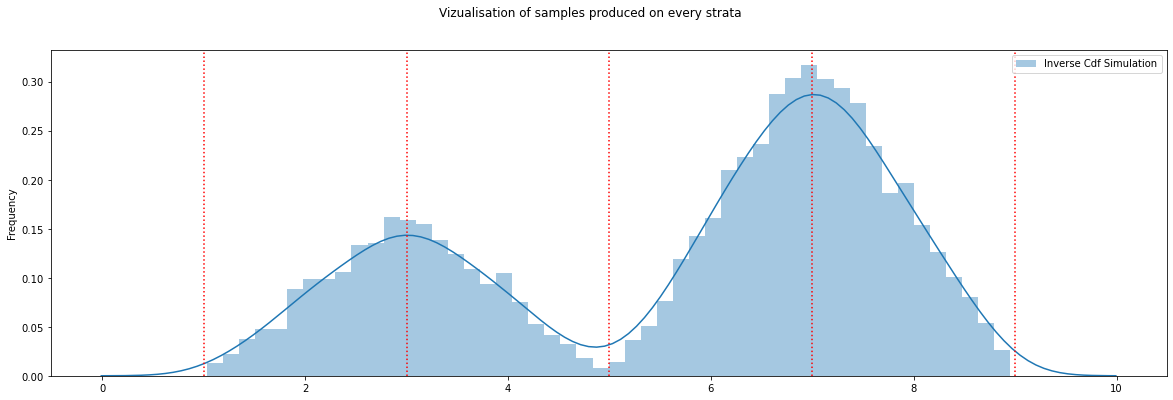

In [340]:
fig, axes = plt.subplots(1, figsize = (20, 6))
fig.suptitle('Vizualisation of samples produced on every strata')
axes.set_ylabel('Density Value')
sns.distplot(Xis, bins = 50, label='Inverse Cdf Simulation')
axes.set_ylabel('Frequency')
for stratus in strata:
    plt.axvline(x=stratus, linestyle=':', color='red')
axes.legend(loc='best')
plt.show()

The samples produced on every strata through inverse cdf sampling are of good quality, as expected from the sampling leveraging the Inverse cdf method. 

## Part III: Variance Reduction

1. Compute the sample variance of the four Monte Carlo estimates in Part I. Based on the discussions in lecture, which sampling methods (and proposal/importance distributions) is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?<br><br>

3. Based on your experiments, would you feel comfortable concluding which type of Monte Carlo estimate will **generally** have the lowest variance? Why or why not?<br><br>

4. (**Extra Credit**) Implement the control variate Monte Carlo estimate for $I$ for your choice of a control variate $g$ and sample using the inverse CDF sampler. Argue for why your choice of $g$ is appropriate and demonstrate that your control variate estimate has lower variance than the naive Monte Carlo using inverse CDF sampling.

#### Variance Reduction for our samplers 

In [346]:
S = 100

#### Naive Monte Carlo Estimate using Inverse CDF sampling

In [347]:
estimation_mc_naive = []
for i in range(S):
    U = np.random.uniform(0, 1, size = 1000)
    Xis = [cdf_inv(u) for u in U]
    H = [h(Xi) for Xi in Xis]
    I = np.mean(H)
    estimation_mc_naive.append(I)
print(np.std(estimation_mc_naive))

0.05947427733699311


#### Naive Monte Carlo Estimate using Rejection Sampling with a uniform Proposal Distribution

In [353]:
M1 = 3
estimation_mc_rejection_uniform = []
for j in range(S):
    accepted_samples_unif = []
    for i in range(1000):
        Y_tent = np.random.uniform(1, 9)
        threshold = np.random.uniform(0, 1)
        if threshold*M1*1/9 < pdf(Y_tent):
            accepted_samples_unif.append(Y_tent)
    H = [h(Xi) for Xi in accepted_samples_unif]
    I = np.mean(H)
    estimation_mc_rejection_uniform.append(I)
print(np.std(estimation_mc_rejection_uniform))

0.10160658058339979


#### Naive Monte Carlo Estimation using Rejection Sampling with a Gaussian Proposal Distribution

In [ ]:
M2 = 3
accepted_samples_Gaussi = []
for i in range(1000):
    Y_tent = np.random.normal(mu, sigma)
    threshold = np.random.uniform(0, 1)
    if threshold*M2*scipy.stats.norm.pdf(Y_tent, mu, sigma) < pdf(Y_tent):
        accepted_samples.append(Y_tent)

#### Importance Sampling Estimate: Uniform Important Distribution

In [350]:
estimation_mc_imp_unif = []
for i in range(S):
    samples = np.random.uniform(1, 9, 1000)
    weights = np.asarray([pdf(sample)/(1/9) for sample in samples])
    H = np.asarray([h(u) for u in samples])
    I_imp_sampling = np.mean(weights*H)
    estimation_mc_imp_unif.append(I_imp_sampling)
print(np.std(estimation_mc_imp_unif))

0.06766485288025803


#### Importance Sampling Estimate: Gaussian Important Distribution

In [351]:
mu = 5.6
sigma= 3.2
estimation_mc_imp_gaussian = []
for i in range(S):
    samples = np.random.normal(mu, sigma, 1000)
    weights = np.asarray([pdf(sample)/scipy.stats.norm.pdf(sample, mu, sigma) for sample in samples])
    H = np.asarray([h(x) for x in samples])
    I_imp_sampling = np.mean(weights*H)
    estimation_mc_imp_gaussian.append(I_imp_sampling)
print(np.std(estimation_mc_imp_gaussian))

0.06949843895518693


#### Stratification with Inverse cdf sampling

In [352]:
estimation_mc_strata = []
for i in range(S):   
    U = np.random.uniform(0, 1, size = 10000)
    Xis = np.array([cdf_inv(u) for u in U])
    strata_1 = random.sample(list(Xis[Xis < 3]), k=S1)
    strata_2 = random.sample(list(Xis[(Xis > 3) & (Xis < 5)]), k=S2)
    strata_3 = random.sample(list(Xis[(Xis > 5) & (Xis < 7)]), k=S3)
    strata_4 = random.sample(list(Xis[(Xis > 7) & (Xis < 9)]), k=S4)
    h1 = [h(s1) for s1 in strata_1]
    h2 = [h(s2) for s2 in strata_2]
    h3 = [h(s3) for s3 in strata_3]
    h4 = [h(s4) for s4 in strata_4]
    I_strata = np.sum([w1*np.mean(h1), w2*np.mean(h2), w3*np.mean(h3), w4*np.mean(h4)])
    estimation_mc_strata.append(I_strata)
print(np.std(estimation_mc_strata))

0.02154797516038642


From the lectures, the sampling methods expected to result in lower variances are Importance Sampling and Stratification Sampling. However, based on the results we got here, we can assess several things: 

- The rejection samplings methods are less accurate than others. This can be explained by the fact that, from what we have seen before, less samples are accepted via rejection sampling and this is why our estimation is less accurate. Moreover, since less samples are accepted for Rejection Sampling with a Gaussian Proposal Distribution than with a Uniform Gaussian Distribution, the former estimation has more Variance. 
- For the importance sampling, we do not achieve expected results. This come from the fact that we have already seen in Part II that the choice we made for important distribution is unsuitable both for $f_X$ and $h$.
- Stratification with inverse cdf sampling is highly effective here. I would not have expected it to procure such a variance reduction due to the fact that the strata were not that tund regarding the variations of h. This implies that there will be room for further improvement for selecting the strata. 

#### General conclusions 

From our non-exhaustive study of Monte-Carlo Variance Reduction + Sampling techniques, I would not be confident with making global conclusions on the behavior of certain samplers or certain Variance Reduction techniques. The only thing I would be confident with is saying that there are no absolute best methods and that we need to pay a close attention to how we leveraged some techniques (for instance here we used Variance Reduction Importance Sampling Technique the wrong way and resulted in an Increase of the Variance).

#### Control Variable: design a Random Variable that would have a high correlation with 